# LSTM Network

In [ ]:
import os, sys
import datetime

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv1D, MaxPooling1D, MultiHeadAttention, LayerNormalization, Add

# TF optimizations for laptop
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Hide all GPUs from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce verbose logging
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'  # Enable OneDNN optimizations
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce verbose logging
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'  # Enable OneDNN optimizations
tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(2)# Verify CPU-only mode
print("Available devices:", tf.config.list_physical_devices())
print("GPU available:", tf.config.list_physical_devices('GPU'))

LOCAL = True
rootpath = os.path.dirname(os.path.dirname(os.getcwd()))
print(f"rootpath: {rootpath}")
# module_path = os.path.abspath(os.path.join(rootpath, 'src'))
# sys.path.insert(0, module_path)
sys.path.append(os.path.dirname(os.path.abspath('.')))
import data_challenge as data
import models_challenge as models

2025-07-17 16:37:51.678702: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-17 16:37:51.687625: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-17 16:37:51.707941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752763071.738215 3854410 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752763071.746673 3854410 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752763071.767109 3854410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU available: []
rootpath: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting


2025-07-17 16:37:56.151393: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
if LOCAL:
    dirfpath = data.download_stock_price_prediction_challenge_data(rootpath)
    test_path = os.path.join(dirfpath, "test")
    train_stocks_path = os.path.join(dirfpath, "train", "stocks")
    train_indices_path = os.path.join(dirfpath, "train", "indices")
    
else:
    test_path = "/kaggle/input/stock-price-prediction-challenge/test"
    train_stocks_path = "/kaggle/input/stock-price-prediction-challenge/train/stocks"
    train_indices_path = "/kaggle/input/stock-price-prediction-challenge/train/indices",

paths = {
    'test_path': test_path,
    'train_stocks_path': train_stocks_path,
    'train_indices_path': train_indices_path}

Raw data already found in location /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data/stock-price-prediction-challenge.zip
Raw data already unzipped


## Helper Functions


In [3]:
def build_scalers(X_train, y_train, X_test, y_test):
    Xscaler = MinMaxScaler(feature_range=(0, 1))
    yscaler = MinMaxScaler(feature_range=(0, 1))
    X_train_scaled = Xscaler.fit_transform(X_train)
    X_test_scaled = Xscaler.transform(X_test)
    y_train_scaled = yscaler.fit_transform(y_train)
    y_test_scaled = yscaler.transform(y_test)
    return Xscaler, yscaler, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled

earlystop_cb = EarlyStopping(
    monitor='val_loss',        # metric to watch
    min_delta=1e-4,            # minimum change to qualify as improvement
    patience=5,                # how many epochs with no improvement before stopping
    verbose=1,                 # prints a message when stopping
    restore_best_weights=True  # at end of training, rolls back to the best weights
)
reducelr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,      # reduce LR by this factor
    patience=3,      # after how many bad epochs
    verbose=1
)


## CNN-LSTM Model

In [4]:
target = 'Returns'
df = data.get_ticker_df('test_4', test_path, train_stocks_path)
df = data.add_indice_features(df, target, train_indices_path)
df = data.prepare_features(df, target=target, beta_window=10, ma_windows=[10, 20, 60], ewm_alpha=[0.1, 0.3, 0.5], lags=1, out_len=500)
train_df, test_df = data.split_df(df, train_ratio=0.8)
X_train, y_train = models.get_X_y_multistep(train_df, steps=11, target='Returns')
X_test, y_test = models.get_X_y_multistep(test_df, steps=11, target='Returns')

shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)


In [5]:
def build_cnn_lstm(params):
    model = Sequential()
    model.add(Input(shape=(params['num_features'], 1)))
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=64))
    model.add(Dense(units=params['num_outputs'])) 
    model.compile(optimizer='adam', loss=params['loss'])
    return model

In [10]:
params = {
    'num_features': X_train.shape[1],
    'num_outputs': y_train.shape[1],
    'loss': 'mean_squared_error'
}
model = build_cnn_lstm(params)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 14, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 7, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 7, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,227 (286.04 KB)

 Trainable params: 73,227 (286.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
Xscaler, yscaler, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = build_scalers(X_train, y_train, X_test, y_test)
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    verbose=1,
    callbacks=[earlystop_cb, reducelr_cb] # , tensorboard_cb
    )

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0509 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0114 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0082 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0060 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0068 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0064 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0059 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0056 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0053 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 10/

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Train RMSE: 0.03540
Test RMSE: 0.02767


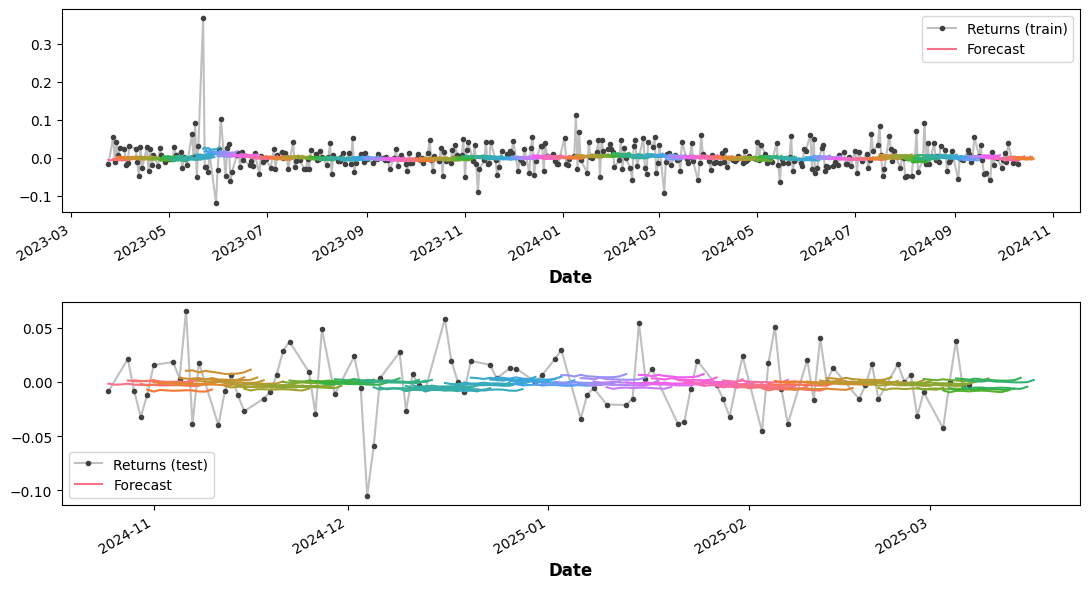

In [8]:
# train performance
y_hat_train = model.predict(X_train_scaled)
y_hat_train= yscaler.inverse_transform(y_hat_train)
y_hat_train = pd.DataFrame(y_hat_train, columns=y_train.columns, index=y_train.index)
# test prediction
y_hat_test = model.predict(X_test_scaled)
y_hat_test= yscaler.inverse_transform(y_hat_test)
y_hat_test = pd.DataFrame(y_hat_test, columns=y_test.columns, index=y_test.index)
models.evaluate_multistep(y_train, y_hat_train, y_test, y_hat_test, df, target)

## LSTM-Attention Model

In [9]:
target = 'Returns'
df = data.get_ticker_df('test_4', test_path, train_stocks_path)
df = data.add_indice_features(df, target, train_indices_path)
df = data.prepare_features(df, target=target, beta_window=10, ma_windows=[10, 20, 60], ewm_alpha=[0.1, 0.3, 0.5], lags=1, out_len=500)
train_df, test_df = data.split_df(df, train_ratio=0.8)
X_train, y_train = models.get_X_y_multistep(train_df, steps=11, target='Returns')
X_test, y_test = models.get_X_y_multistep(test_df, steps=11, target='Returns')

shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)


In [ ]:
def build_lstm_attention(params):
    # hyperparams
    units_lstm = 50
    drop_lstm = 0.2
    drop_attn = 0.1
    num_heads = 4
    key_dim = 16
    # dense_units = 32
    # drop_dense = 0.2

    # Inputs
    inputs = Input(shape=(params['num_features'], 1), name="inputs")

    # First LSTM layer (return_sequences for attention)
    x = LSTM(units_lstm, return_sequences=True, name="lstm_1")(inputs)
    x = Dropout(drop_lstm, name="drop_lstm_1")(x)

    # Self‐Attention block
    attn = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
        name="multihead_attn"
    )(x, x)
    attn = Dropout(drop_attn, name="drop_attn")(attn)

    # Residual + LayerNorm
    x = Add(name="residual_add")([x, attn])
    x = LayerNormalization(name="layer_norm")(x)

    # Second LSTM (no need to return sequences)
    x = LSTM(units_lstm, return_sequences=False, name="lstm_2")(x)
    x = Dropout(drop_lstm, name="drop_lstm_2")(x)
    
    # Extra Dense hidden layer
    # x = Dense(dense_units, activation='relu', name="dense_hidden")(x)
    # x = Dropout(drop_dense, name="drop_dense")(x)
    
    # Final output
    outputs = Dense(params['num_outputs'] , activation='linear', name="predictions")(x)

    model = Model(inputs, outputs, name="LSTM_with_Attention")
    model.compile(optimizer='adam', loss=params['loss'])
    return model

In [31]:
params = {
    'num_features': X_train.shape[1],
    'num_outputs': y_train.shape[1],
    'loss': 'mean_squared_error'
}
model = build_lstm_attention(params)
model.summary()

Model: "LSTM_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 16, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 16, 50)    │     10,400 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_lstm_1         │ (None, 16, 50)    │          0 │ lstm_1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attn      │ (None, 16, 50)    │     13,042 │ drop_lstm_1[0][0… │
│ (MultiHeadAttentio… │                   │            │ drop_lstm_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_attn (Dropout) │ (None, 16, 50)    │          0 │ multihead_attn[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_add (Add)  │ (None, 16, 50)    │          0 │ drop_lstm_1[0][0… │
│                     │                   │            │ drop_attn[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm          │ (None, 16, 50)    │        100 │ residual_add[0][… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 50)        │     20,200 │ layer_norm[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_lstm_2         │ (None, 50)        │          0 │ lstm_2[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 11)        │        561 │ drop_lstm_2[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 44,303 (173.06 KB)

 Trainable params: 44,303 (173.06 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
Xscaler, yscaler, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = build_scalers(X_train, y_train, X_test, y_test)
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    verbose=1,
    callbacks=[earlystop_cb, reducelr_cb] # , tensorboard_cb
    )

Epoch 1/100


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0936 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0320 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0212 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0148 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0124 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0116 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0100 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0092 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0091 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 10/100
13/13 ━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Train RMSE: 0.03557
Test RMSE: 0.02762


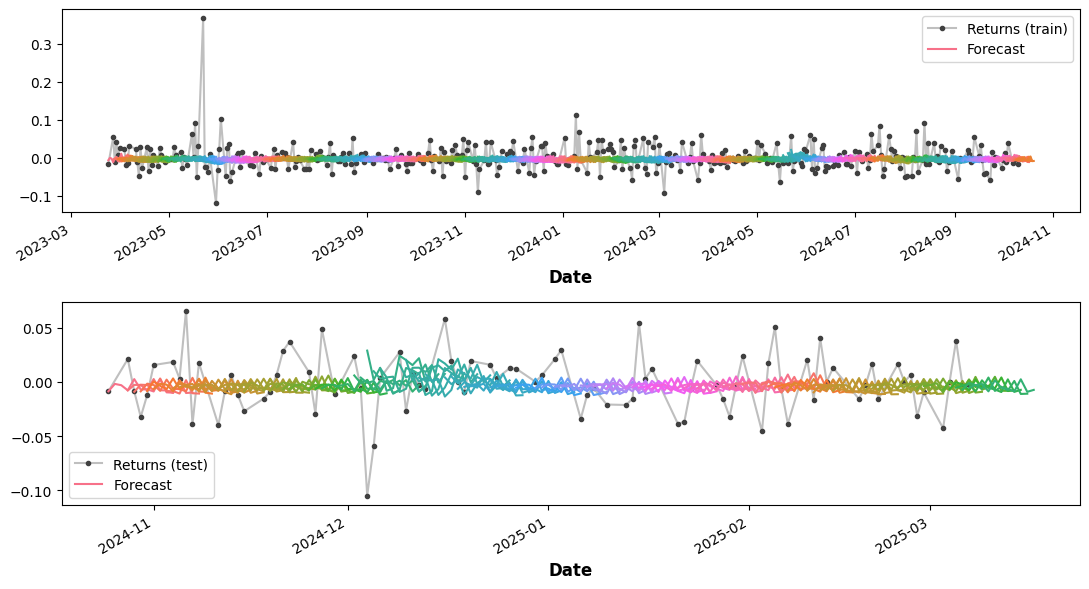

In [33]:
# train performance
y_hat_train = model.predict(X_train_scaled)
y_hat_train= yscaler.inverse_transform(y_hat_train)
y_hat_train = pd.DataFrame(y_hat_train, columns=y_train.columns, index=y_train.index)
# test prediction
y_hat_test = model.predict(X_test_scaled)
y_hat_test= yscaler.inverse_transform(y_hat_test)
y_hat_test = pd.DataFrame(y_hat_test, columns=y_test.columns, index=y_test.index)
models.evaluate_multistep(y_train, y_hat_train, y_test, y_hat_test, df, target)

## CNN-LSTM-Attention Model

In [34]:
def build_cnn_lstm_attention(params):
    # hyperparams
    conv_filters = 32
    conv_kernel = 3
    pool_size = 2
    units_lstm = 50
    drop_lstm = 0.2
    drop_attn = 0.1
    num_heads = 4
    key_dim = 16
    dense_units = 32
    drop_dense = 0.2

    # Inputs
    inputs = Input(shape=(params['num_features'], 1), name="inputs")

    x = Conv1D(conv_filters, conv_kernel, activation='relu', padding='causal', name="conv1d")(inputs)
    x = MaxPooling1D(pool_size, name="maxpool")(x)

    # First LSTM layer (return_sequences for attention)
    x = LSTM(units_lstm, return_sequences=True, name="lstm_1")(x)
    x = Dropout(drop_lstm, name="drop_lstm_1")(x)

    # Multihead Self‐Attention + Residual & LayerNorm
    attn = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
        name="multihead_attn"
    )(x, x)
    attn = Dropout(drop_attn, name="drop_attn")(attn)
    x = Add(name="residual_add")([x, attn])
    x = LayerNormalization(name="layer_norm")(x)

    # Second LSTM (no need to return sequences)
    x = LSTM(units_lstm, return_sequences=False, name="lstm_2")(x)
    x = Dropout(drop_lstm, name="drop_lstm_2")(x)

    # Extra Dense hidden layer
    x = Dense(dense_units, activation='relu', name="dense_hidden")(x)
    x = Dropout(drop_dense, name="drop_dense")(x)

    # Final output
    outputs = Dense(params['num_outputs'] , activation='linear', name="predictions")(x)

    model = Model(inputs, outputs, name="LSTM_with_Attention")
    model.compile(optimizer='adam', loss=params['loss'])
    return model

In [35]:
params = {
    'num_features': X_train.shape[1],
    'num_outputs': y_train.shape[1],
    'loss': 'mean_squared_error'
}
model = build_cnn_lstm_attention(params)
model.summary()

Model: "LSTM_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 16, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 16, 32)    │        128 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool             │ (None, 8, 32)     │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 8, 50)     │     16,600 │ maxpool[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_lstm_1         │ (None, 8, 50)     │          0 │ lstm_1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attn      │ (None, 8, 50)     │     13,042 │ drop_lstm_1[0][0… │
│ (MultiHeadAttentio… │                   │            │ drop_lstm_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_attn (Dropout) │ (None, 8, 50)     │          0 │ multihead_attn[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_add (Add)  │ (None, 8, 50)     │          0 │ drop_lstm_1[0][0… │
│                     │                   │            │ drop_attn[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm          │ (None, 8, 50)     │        100 │ residual_add[0][… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 50)        │     20,200 │ layer_norm[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_lstm_2         │ (None, 50)        │          0 │ lstm_2[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_hidden        │ (None, 32)        │      1,632 │ drop_lstm_2[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_dense          │ (None, 32)        │          0 │ dense_hidden[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 11)        │        363 │ drop_dense[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,065 (203.38 KB)

 Trainable params: 52,065 (203.38 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
Xscaler, yscaler, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = build_scalers(X_train, y_train, X_test, y_test)
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    verbose=1,
    callbacks=[earlystop_cb, reducelr_cb] # , tensorboard_cb
    )

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 0.0849 - val_loss: 0.0218 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0376 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0277 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0218 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0174 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0146 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0133 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0113 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0104 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 10/

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Train RMSE: 0.03505
Test RMSE: 0.02697


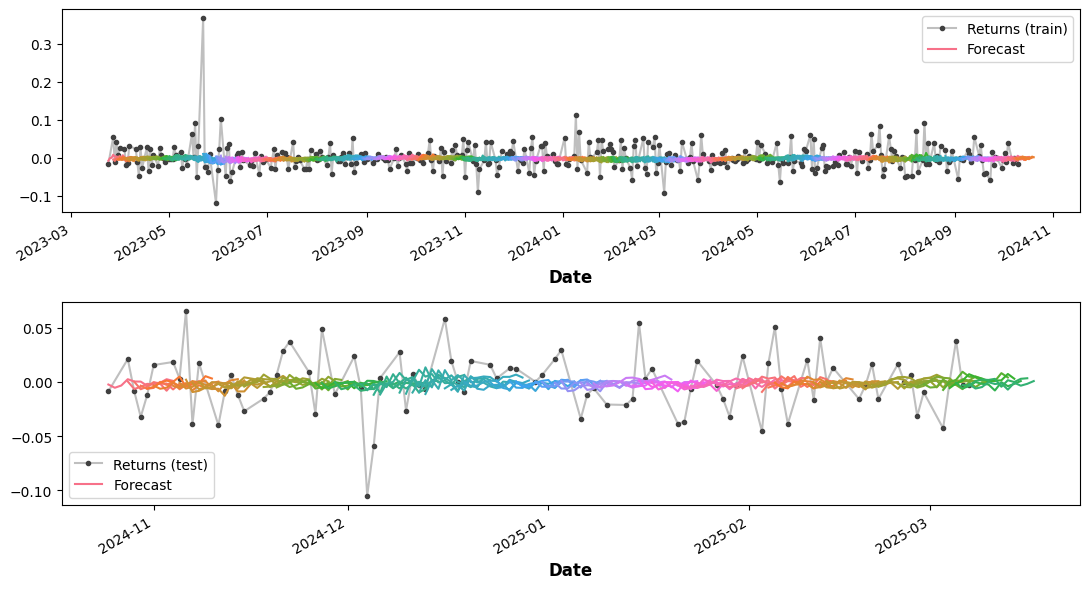

In [37]:
# train performance
y_hat_train = model.predict(X_train_scaled)
y_hat_train= yscaler.inverse_transform(y_hat_train)
y_hat_train = pd.DataFrame(y_hat_train, columns=y_train.columns, index=y_train.index)
# test prediction
y_hat_test = model.predict(X_test_scaled)
y_hat_test= yscaler.inverse_transform(y_hat_test)
y_hat_test = pd.DataFrame(y_hat_test, columns=y_test.columns, index=y_test.index)
models.evaluate_multistep(y_train, y_hat_train, y_test, y_hat_test, df, target)

In [ ]:
params = {}
tickers = ['test_1', 'test_2', 'test_3', 'test_4', 'test_5']
forecasts = models.run_forecasts(
    model_builder=build_cnn_lstm,
    params=params,
    model_type='NN',
    tickers=tickers,
    paths=paths
    )

In [ ]:
models.create_submission_file(forecasts, rootpath, tickers, fnamesuffix='_XGBRegChain')